## Prepare environmental variables

Download the dataset and import the necessary packages.

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

import warnings


In [45]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [46]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

C:\Users\elena\AppData\Local\Temp\ipykernel_3664\1948943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['free_sulfur_dioxide'], inplace=True)


## Performance evaluation of classification models

Now, we will prepare some structures to evaluate the classification models.

In [47]:
#Let us create first create a table to store the results of various models 
metrics =['Accuracy', 'Precision Macro','Precision Weigthed','Recall Macro', 'Recall Weighted','F1-score Macro', 'F1-score Weighted']
classification_results = pd.DataFrame(columns=metrics)
# all_confusion_matrices = {}

In [48]:
#Classification Summary Function
def report_classification(y_test, pred, model_name, conf_matrix):
    a = accuracy_score(y_test,pred)
    pm, rm, fm, _ = precision_recall_fscore_support(y_test,pred, average='macro')
    pw, rw, fw, _ = precision_recall_fscore_support(y_test,pred, average='weighted')
    classification_results.loc[model_name] = [a, pm, pw, rm, rw, fm, fw]
    print("============= METRICS FOR MODEL : ", model_name, " =================")
    print(classification_report(y_test,pred))
    print("==================== CONFUSION MATRIX ==========================")
    # all_confusion_matrices[model_name] = conf_matrix
    conf_matrix.plot(cmap=plt.cm.Blues)
    plt.title("Confussion Matrix for "+model_name)
    plt.savefig("img_classification/"+model_name+".png")
    plt.show()

### Naïve Bayes

Naïve Bayes is a classiffication algorithm based on Bayes' theorem. It assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. Its aim is to predict that the n-dimensional feature vector $X=(x_1,x_2,...,x_n)$ belongs to class $Y_i$, encountered within a set of classes $C=(Y_1,Y_2,...,Y_n)$ that verifies this condition:

arg max $(P(Y_i|X))$.

This algorithm would only work in the case of categorical features, in algorithms like **Multinomial Naïve Bayes**.

In order to estimate the class-conditional probabilities for continuous features, there are well-known techniques which assume that the likelihood of the features follows a certain probability distribution. **Gaussian Naïve Bayes**, for example, assumes a Gaussian distribution.

#### Gaussian Naïve Bayes

Gaussian Naïve Bayes assumes Gaussian distribution for the likelihood of numeric continuous features:

$g(x_i,μ,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}e^\frac{(x_i-μ)^2}{2\sigma^2}$

so that the likelihood of the features is calculated as:

$P(X_i = x_i|Y_i = y_i)=g(x_i,μ_{Y_i},\sigma_{Y_i})$

This algorithm is suitable for the dataset, as it contains a discrete target feature. The main issue will be to perform discretization on the target variable, which is still numeric.

In [49]:
from sklearn.preprocessing import KBinsDiscretizer

bins = (2, 5.5, 9)
labels= ["poor quality", "nice quality"]

# Perform discretization on the continuous features
y_discretized = pd.cut(df_wine['quality'], bins=bins, labels=labels)

# Show that the target has been discretized
y_discretized

0       poor quality
1       poor quality
2       poor quality
3       nice quality
4       poor quality
            ...     
6492    nice quality
6493    poor quality
6494    nice quality
6495    nice quality
6496    nice quality
Name: quality, Length: 6497, dtype: category
Categories (2, object): ['poor quality' < 'nice quality']

The target variable is now categorical, so the Gaussian Naïve Bayes algorithm can be used. Its most important assumption is the normality of the data, this means, that if the features used are normally distributed, the algorithm will perform better. This normality can be checked by plotting the histogram of the features, as seen below:

In [50]:
print("============= Variance for each feature =============")
print(X.var())

============= Variance for each feature =============
fixed_acidity              1.680740
volatile_acidity           0.027105
citric_acid                0.021117
residual_sugar            22.636696
chlorides                  0.001227
total_sulfur_dioxide    3194.720039
density                    0.000009
pH                         0.025853
sulphates                  0.022143
alcohol                    1.422561
dtype: float64


<Figure size 1600x1600 with 0 Axes>

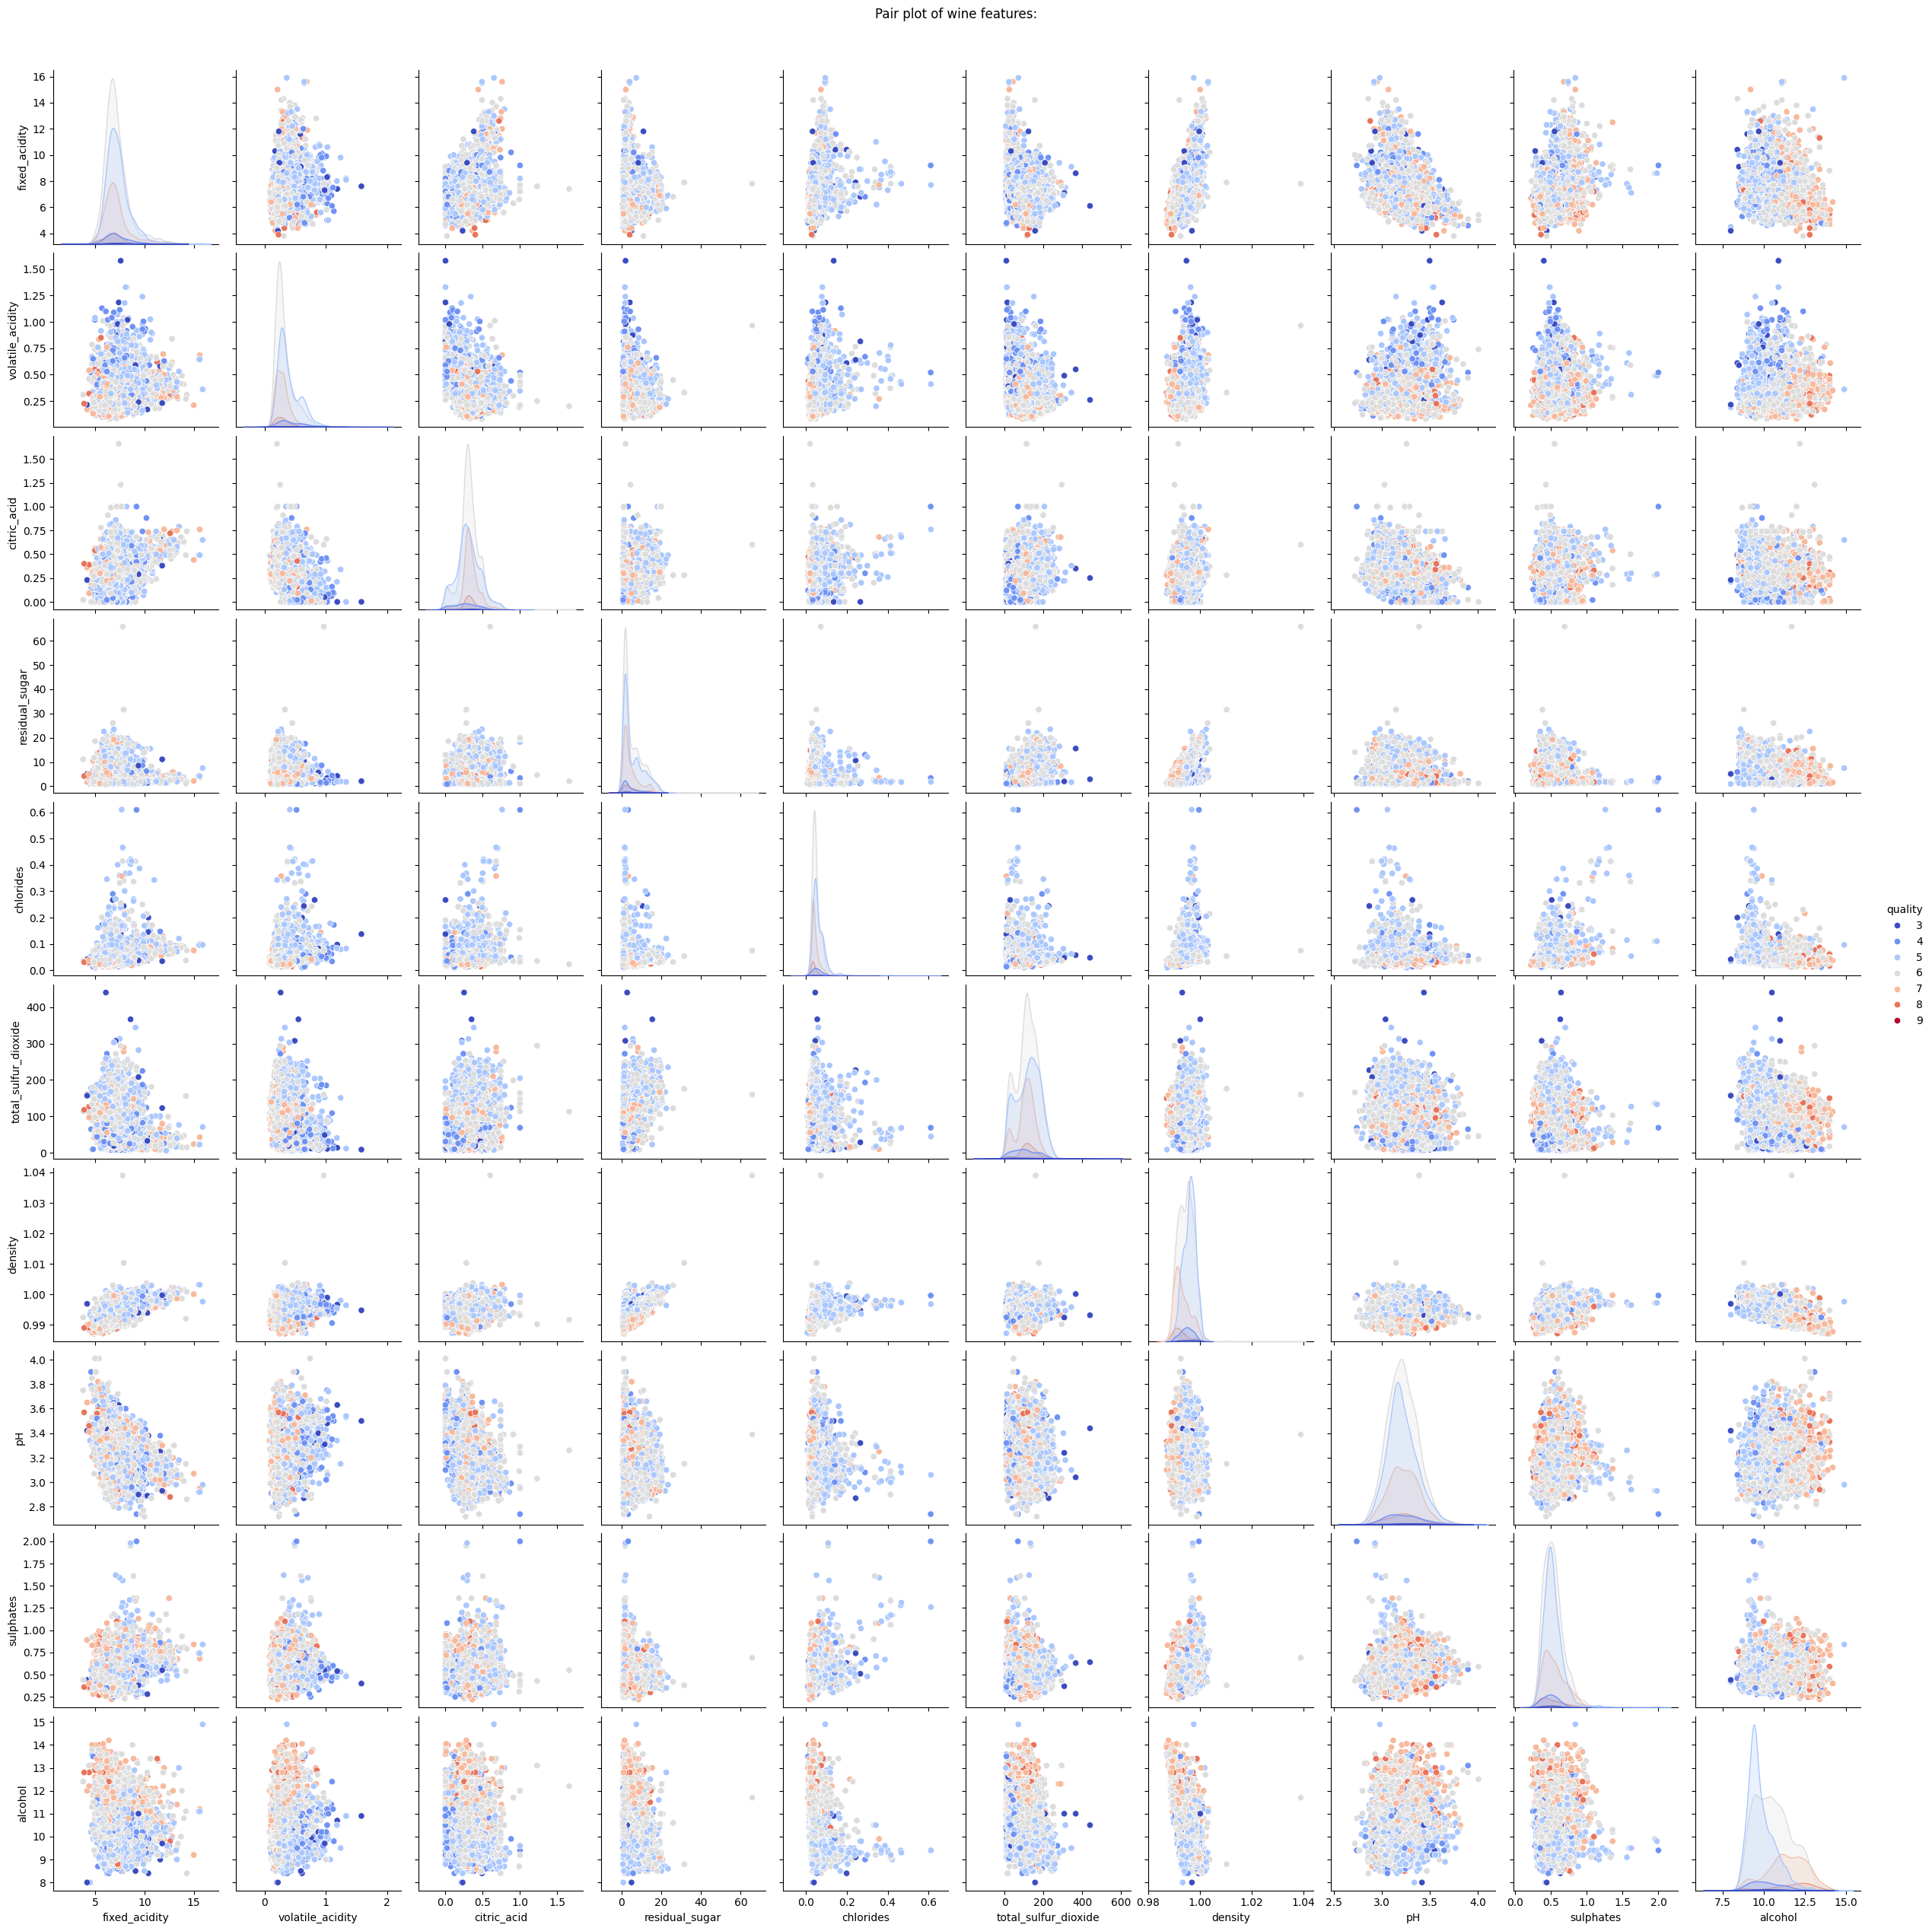

In [51]:
plt.figure(figsize=(16, 16))
# Pair plot with the quality variable as the hue
sns.pairplot(df_wine, hue='quality', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pair plot of wine features:', y=1.02)
plt.show()

We can see that there is a subset of features whose relation follows a probability distribution close to normality. Those are `fixed_acidity`,`citric_acid`, `ph` and `sulphates`. We will use this for the Gaussian Naïve Bayes algorithm.

In [52]:
from sklearn.naive_bayes import GaussianNB

# Create the Naive Bayes model and select features with normality
gaussian_nb_classifier = GaussianNB()
selected_features = ['fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'alcohol']
X_selected = X[selected_features]

# Separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_discretized, test_size=0.2, random_state=42)

gaussian_nb_classifier.fit(X_train, y_train)

y_pred = gaussian_nb_classifier.predict(X_test)

With the model trained and tested, some metrics are extracted:

Other metrics can be extracted from this, such as a summary or a confusion matrix:

============= METRICS FOR MODEL :  GaussianNB  =================
              precision    recall  f1-score   support

nice quality       0.79      0.70      0.74       849
poor quality       0.54      0.65      0.59       451

    accuracy                           0.68      1300
   macro avg       0.66      0.68      0.67      1300
weighted avg       0.70      0.68      0.69      1300

==================== CONFUSION MATRIX ==========================


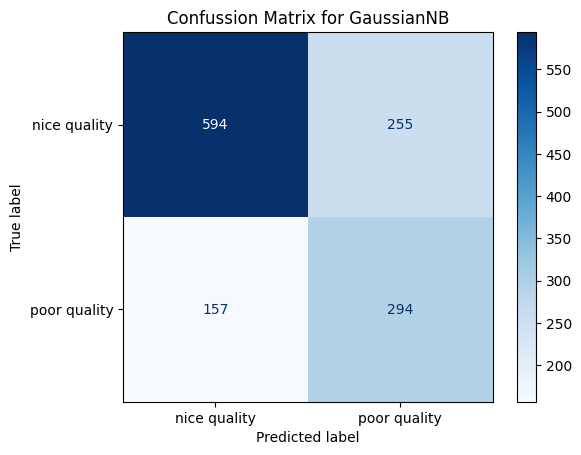

In [53]:
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)

report_classification(y_test, y_pred, 'GaussianNB', cm_display)

**Conclusion:** The rates are quite equal either for classifying the quality of the wine as good or bad, and are both above 50%. This means the model has nice performance measures, but they can be by far improved by other models. Without considering the room for improvement, the increase of performance by the use of a classification model (suitable for the proposed problem) is clearly noticeable.

#### Multinomial Naïve Bayes

Multinomial Naïve Bayes is a variant of Naïve Bayes that is used for multinomially distributed data. It assumes that the features are independent. The discretization of the target variable will be the same as in the Gaussian Naïve Bayes model.

In [54]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y_discretized, test_size=0.2, random_state=42)

In [56]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)
y_pred_mnb = multinomial_nb.predict(X_test)
# print("Value of ROC AUC ",roc_auc_score(y_test, mnb.predict_proba(X_test)[:, 1]))

============= METRICS FOR MODEL :  MultinomialNB  =================
              precision    recall  f1-score   support

nice quality       0.79      0.70      0.74       849
poor quality       0.54      0.65      0.59       451

    accuracy                           0.68      1300
   macro avg       0.66      0.68      0.67      1300
weighted avg       0.70      0.68      0.69      1300

==================== CONFUSION MATRIX ==========================


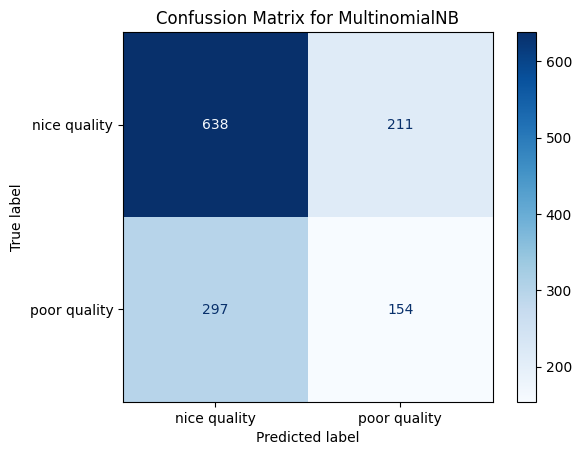

In [57]:
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_mnb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)

report_classification(y_test, y_pred, 'MultinomialNB', cm_display)

The results shows that the Multinomial Naïve Bayes is very good at predicting a nice quality but horrible at predicting poor quality:
* nice quality f1-score is 0.71
* poor quality f1-score is 0.39

This is because the dataset is unbalanced, so the model is biased towards the majority class. So, if the objective was to determine if a wine is good, this model would fit well. However, if the objective is to determine the quality in general, it is better to modify the dataset to balance the classes.

**Conclusion:** The model has a good performance with f1_weighted = 0.59, but it is biased towards the majority class. 
There is room for improvement, for example modifying the dataset which is not the objective of this task.

### Decision Trees

We have already explained [Decision Trees](#Decision-Tree-Regression) in the regression section. In that case, we decided not to use it because the target variable is discrete.

However, in the case of classification, Decision Trees are a good option.

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
dtc = DecisionTreeClassifier(random_state=42)

In [60]:
# y_discretized --> poor [3,5] nice [6,9]
X_train, X_test, y_train, y_test = train_test_split(X,y_discretized, test_size=0.2, random_state=42)

We will use GridSearchCV, not RandomizedSearchCV, to find the best hyperparameters beacuse we want to try all the possible combinations for the criterion parameter.

In [61]:
# Set up the possible hyperparameters 
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth': list(range(2, 30)) + [None], 
    'min_samples_split': [2, 4, 6, 8, 10, 20],  
}

grid_search = GridSearchCV(estimator=dtc,
                           param_grid=param_grid,
                           scoring='f1_macro',  
                           cv=5,  
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 522 candidates, totalling 2610 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, None],
                         'min_samples_split': [2, 4, 6, 8, 10, 20]},
             scoring='f1_macro', verbose=1)

In [62]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best score (f1-macro): {grid_search.best_score_}")

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
Best score (f1-macro): 0.7482495086724786


After training the model, the resulting best hyperparameters are:
* criterion: gini
* max_depth: 20, the maximum depth of the tree.
* min_samples_split: 2, the minimum number of samples required to split an internal node.

The Gini Index criterion considers a binary split for each feature and the best split, the one that maximizes the reduction in impurity is selected. The impurity of a node represents how mixed the classes are in the node. 

============= METRICS FOR MODEL :  DecisionTree  =================
              precision    recall  f1-score   support

nice quality       0.83      0.79      0.81       849
poor quality       0.64      0.69      0.66       451

    accuracy                           0.76      1300
   macro avg       0.73      0.74      0.74      1300
weighted avg       0.76      0.76      0.76      1300

==================== CONFUSION MATRIX ==========================


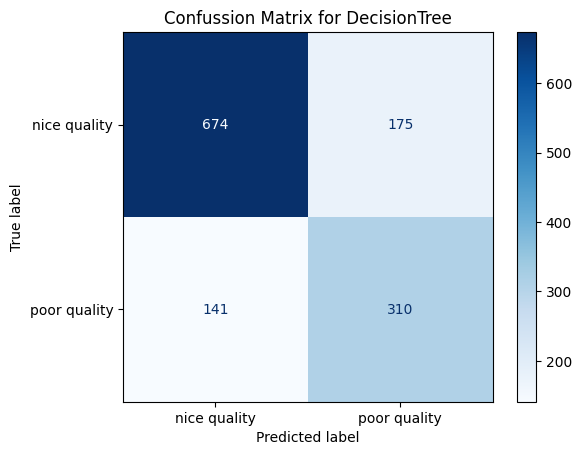

In [63]:
y_pred = best_model.predict(X_test)
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)

report_classification(y_test, y_pred, 'DecisionTree', cm_display)

The metrics show that the model has a good performance in general with 76% of accuracy. Again the model is better at predicting the `nice quality` values but it can perform well with the other class as well.

**Conclusion**: It might be a good model.

### Random Forest Classifier

The Random Forest Classifier needs to be trained on categorical or discrete data, which is the case of the target variable `quality`. Therefore, the target variable will be transformed into a categorical variable with the following bins:
* 3-5: poor quality
* 6-9: nice quality

We choose this binning because the target variable is not balanced at all. The mayority of the wines have a quality of 5 or 6, so we have tried to split it in two categories, to balance the dataset.

In [64]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [65]:
# bins and category labels
bins = (2, 5.5, 9)
labels= ["poor quality", "nice quality"]

y_disc = pd.cut(df_wine['quality'], bins=bins, labels=labels)
X_disc = df_wine.drop(columns=['quality'])

df_wine_discretized = pd.concat([X_disc, y_disc], axis=1)

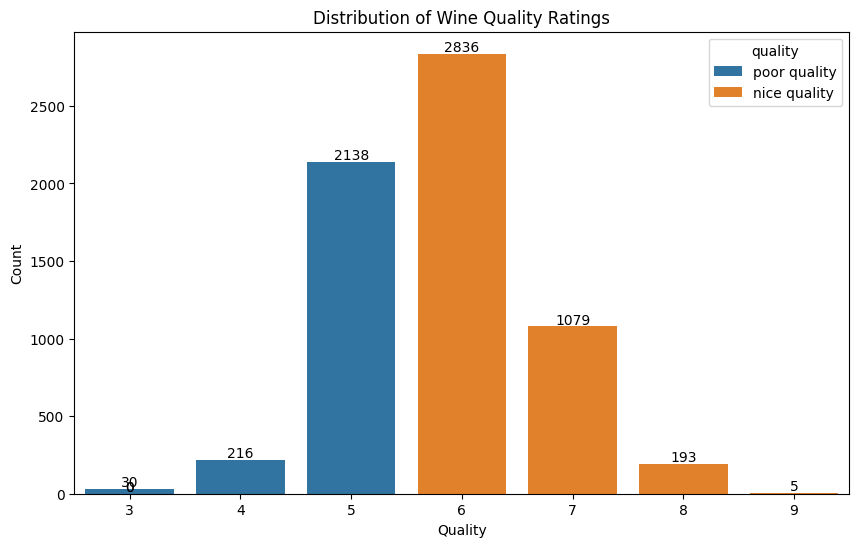

In [66]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='quality', data=df_wine, hue = y_discretized)
plt.title("Distribution of Wine Quality Ratings")
plt.xlabel("Quality")
plt.ylabel("Count")

# Add text as legend
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height() +15), ha='center', va='baseline')
plt.show()

In [67]:
df_wine_discretized['quality'].value_counts()

quality
nice quality    4113
poor quality    2384
Name: count, dtype: int64

After the transformation, the categories are split as follows:
* Nice quality: 4113 instances
* Poor quality: 2384 instances

The classes are still not balanced, but the difference between qualities is not as big as before.

Random Forest is robust to unbalanced classes, as it is based on majority voting. Also, to train it, we will use the parameter `class_weight='balanced'` so the weights of the classes are inversely proportional to the class frequencies. This will help to balance the data and to penalize more the errors in the minority class.

In [68]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(X_disc, y_disc, test_size=0.2, random_state=42)

In [69]:
# Define the parameter distribution for Random Search
param_dist_random = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Initialize Random Search
# n_iter, which controls the number of different combinations to be tested
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist_random,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2,
                                   random_state=42, scoring='f1_weighted')

# Fit the Random Search model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters from Random Search:", random_search.best_params_)
print("Best Score from Random Search:", random_search.best_score_)

# Evaluate on the test set
y_pred = random_search.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters from Random Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 177}
Best Score from Random Search: 0.8182649705912878


============= METRICS FOR MODEL :  RandomForest  =================
              precision    recall  f1-score   support

nice quality       0.85      0.86      0.86       849
poor quality       0.74      0.72      0.73       451

    accuracy                           0.81      1300
   macro avg       0.79      0.79      0.79      1300
weighted avg       0.81      0.81      0.81      1300

==================== CONFUSION MATRIX ==========================


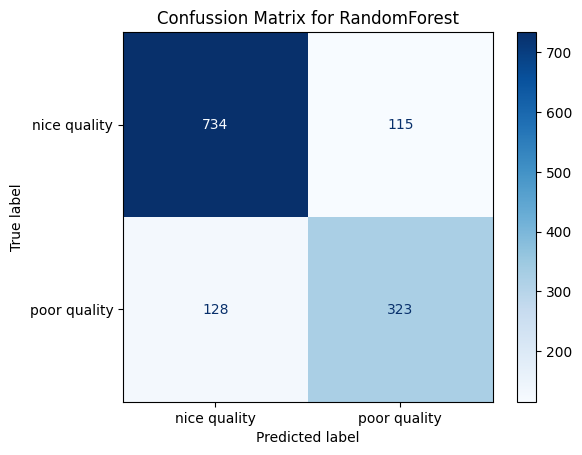

In [70]:
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)

report_classification(y_test, y_pred, 'RandomForest', cm_display)

The metrics are calculated using the parameter `average='weighted'` to take into account the class imbalance.
The accuracy shows a value of 0.82, which means 82% of the predictions are correct. The F1 score is 0.82, which is the metric for imbalance classes.

From the confusion matrix, we can see that the model is good at predicting the 'nice quality' values, but not so good at predicting the 'poor quality' values.

**Conclusion:** The Random Forest Classifier is a good model for this dataset. It has a good accuracy and F1 score, and it is robust to unbalanced classes. It shows a good performance on both of them, although it is better at predicting the 'nice quality' values (the `quality` values from 6 to 9).

### KNN (K-Nearest Neighbors) "Lazy Learner"

The k-Nearest Neighbors algorithm is a lazy learner algorithm that classifies a new data point based on the majority class of its k-nearest neighbors. This means, that a model is not trained, but rather the algorithm searches into de training data.

Decisions are made based on the majority voting for the k-nearest neighbors so they can be affected by the presence irrelevant features or attributes with different scales.

Therefore, it is necessary to scale the data before applying the algorithm. We've decided to use the MinMaxScaler that scales the data but keeps its distribution, so there is no loss of information.

In [71]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

Only the features will be scaled.

In [72]:
#normalize the range of the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Recall that the target variable was encoded into a binary variable, where the quality of the wine is considered good if it is greater than or equal 6 and bad if it is less than 6.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_discretized, test_size=0.2, random_state=42)

In [74]:
# Initialise the kNN classifier
knn = KNeighborsClassifier()

KNN does not have a great variety of hyperparameters to tune, just the number of neighbors and the weights.
* neighbors: the number of neighbors to consider to classify a new data point.
* weights: the weight function used in prediction. The `uniform` means that all points in each neighborhood are weighted equally while `distance` means that the closer neighbors of a query point will have a greater influence than the neighbors that are further away.
  
For this reason, as the number of combinations for the hyperparameters is low and kNN is a fast algorithm, we will use the `GridSearchCV` to find the best hyperparameters.

In [75]:
# Possible parameters
param_grid = {
    'n_neighbors': range(1, 250),
    'weights': ['uniform', 'distance'],
}
# Initialize Grid Search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1_macro',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", grid_search.best_score_)

Fitting 5 folds for each of 498 candidates, totalling 2490 fits
Best Parameters from Grid Search: {'n_neighbors': 62, 'weights': 'distance'}
Best Score from Grid Search: 0.7884985200362967


The best kNN model has the following hyperparameters:
* n_neighbors: 62
* weights: distance
  
Now, we can make the predictions on the test set and evaluate the model.

In [76]:
# Using the best estimator for predictions
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

============= METRICS FOR MODEL :  kNN  =================
              precision    recall  f1-score   support

nice quality       0.84      0.89      0.86       849
poor quality       0.77      0.68      0.72       451

    accuracy                           0.82      1300
   macro avg       0.80      0.78      0.79      1300
weighted avg       0.81      0.82      0.81      1300

==================== CONFUSION MATRIX ==========================


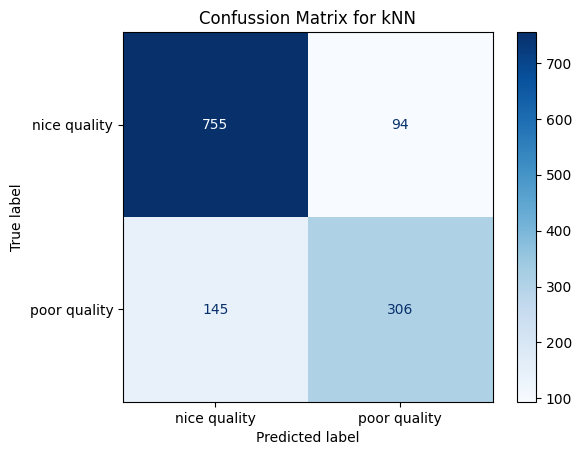

In [77]:
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gaussian_nb_classifier.classes_)

report_classification(y_test, y_pred, 'kNN', cm_display)

The performance metrics shows that in general the model has an 82% of accuracy and a 0.79 as a general f1-score. This means that the model is able to classify the quality of the wine with a good accuracy. However, taking a look at the statistics for each label, we can see that the model is better at classifying the quality of the wine `nice quality` but both of them have a good performance.

**Conclusion**: The kNN model might be a good model.

### Final decision

Here we mention the best model.

=========== COMPARACIÓN DE MODELOS ===========


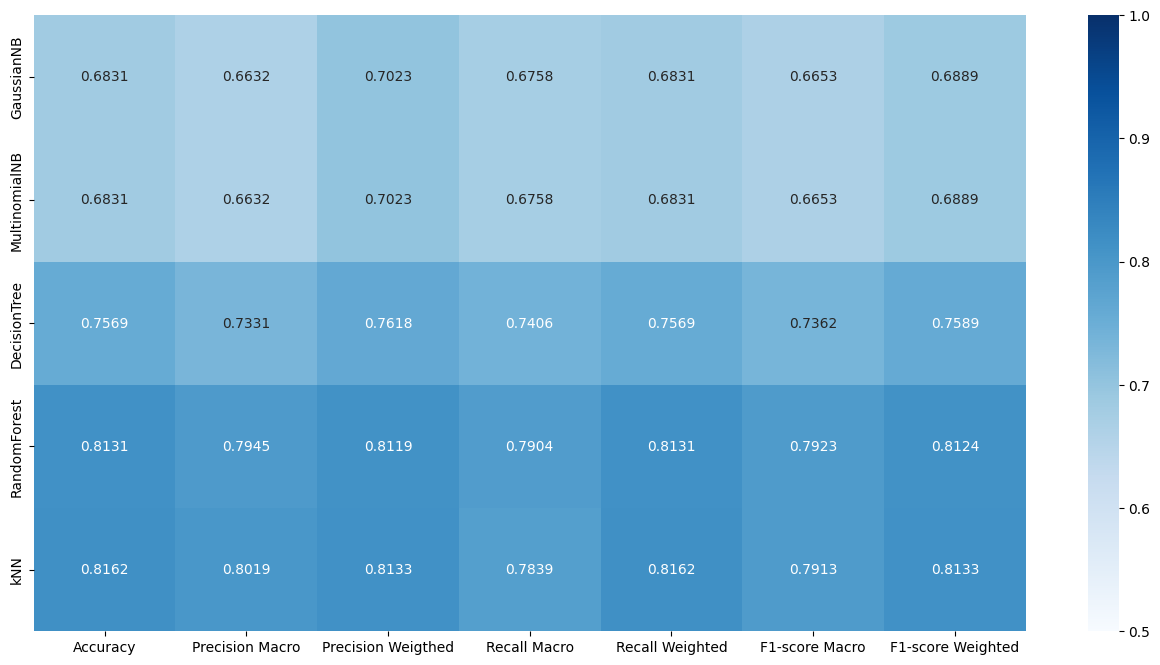

In [78]:
print('=========== COMPARACIÓN DE MODELOS ===========')
plt.figure(figsize=[16,8])
sns.heatmap(classification_results, annot=True, cmap='Blues', fmt='.4f', vmin=0.5, vmax=1)
plt.show()

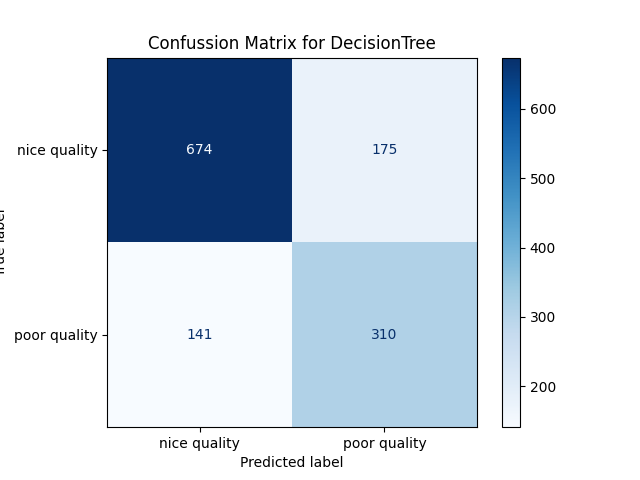

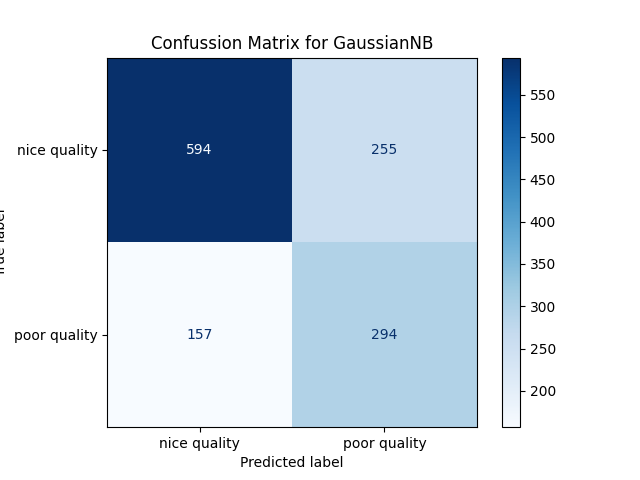

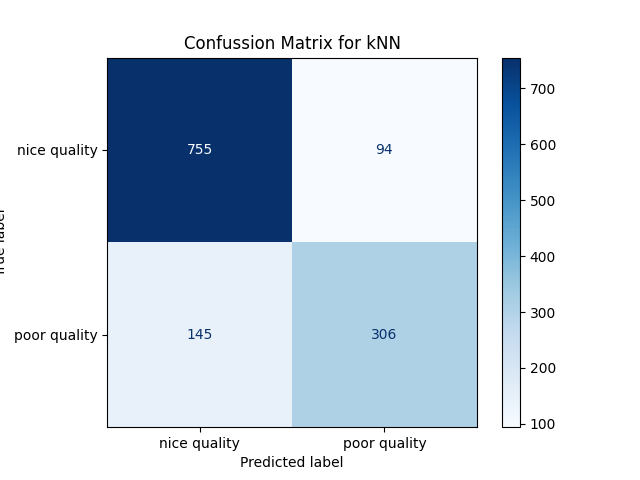

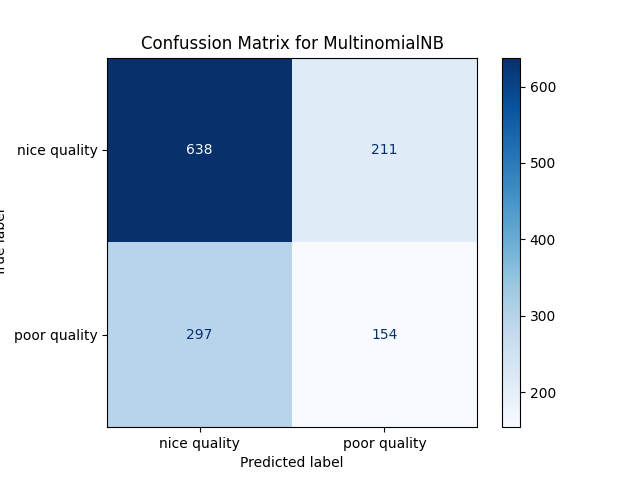

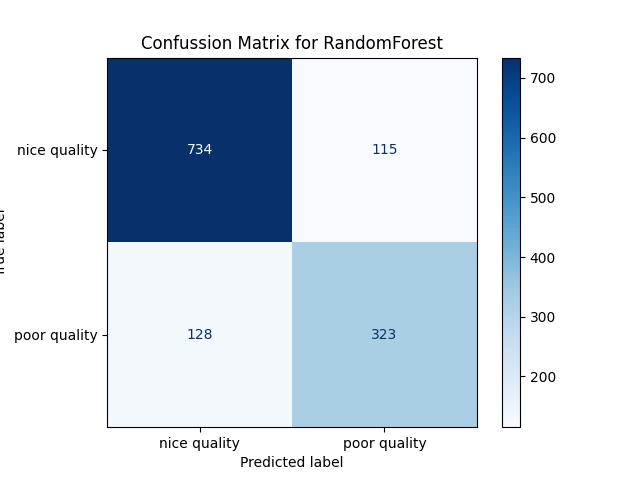

In [80]:
from IPython.display import Image
import os

for file in os.listdir("img_classification"):
    display(Image(filename="img_classification/"+file))